In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
raw_data = pd.read_csv('Data/kc_house_data.csv')

In [3]:
# Data prep and cleaning

# Change to datetime and add month column
raw_data['date'] = pd.to_datetime(raw_data['date'])
raw_data['month'] = pd.DatetimeIndex(raw_data['date']).month

# Change waterfront missing value to No
raw_data.loc[raw_data.waterfront.isnull(), 'waterfront'] = "NO"

# Change view missing value to None
raw_data.loc[raw_data.view.isnull(), 'view'] = "NONE"

# Change condition to numerical value
cond_dict = {'Poor':0, 'Fair':1, 'Average':2, 'Good':3, 'Very Good':4}
raw_data['condition'].replace(cond_dict, inplace=True)

# Change grade to numerical value
raw_data['grade'] = raw_data['grade'].map(lambda x: int(x.split(' ')[0]))

# Add has_basement column
raw_data['basement'] = raw_data['sqft_basement'].apply(lambda x: 0 if x == 0 else 1)

# Change some yr_renovated missing value to 0 and add renovated column
raw_data.loc[raw_data.yr_renovated.isnull(), 'yr_renovated'] = 0
raw_data['renovated'] = raw_data['yr_renovated'].apply(lambda x: 0 if x == 0 else 1)

# Add house_age column
raw_data['age'] = raw_data['date'].dt.year - raw_data['yr_built']

In [4]:
# Drop columns
raw_data.drop(columns=['id', 'yr_renovated', 'sqft_above', 'sqft_basement',
                      'yr_built', 'yr_renovated'], inplace=True)

In [6]:
raw_data.head(3)

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,zipcode,lat,long,sqft_living15,sqft_lot15,month,basement,renovated,age
0,2014-10-13,221900.0,3,1.00,1180,5650,1.0,NO,NONE,2,7,98178,47.5112,-122.257,1340,5650,10,1,0,59
1,2014-12-09,538000.0,3,2.25,2570,7242,2.0,NO,NONE,2,7,98125,47.7210,-122.319,1690,7639,12,1,1,63
2,2015-02-25,180000.0,2,1.00,770,10000,1.0,NO,NONE,2,6,98028,47.7379,-122.233,2720,8062,2,1,0,82


In [7]:
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import scipy.stats as stats
plt.style.use('ggplot')

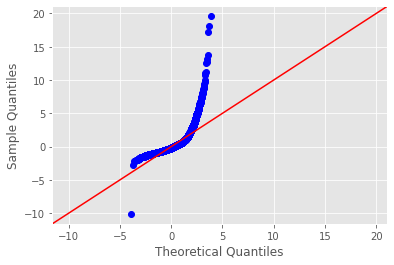

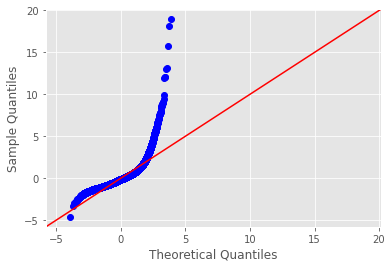

In [12]:
f = 'price~bedrooms'
f2 = 'price~bathrooms'
model = smf.ols(formula=f, data=raw_data).fit()
model2 = smf.ols(formula=f2, data=raw_data).fit()

resid1 = model.resid
resid2 = model2.resid
fig = sm.graphics.qqplot(resid1, dist=stats.norm, line='45', fit=True)
fig = sm.graphics.qqplot(resid2, dist=stats.norm, line='45', fit=True)

In [13]:
# JB test for Bedrooms
name = ['Jarque-Bera','Prob','Skew', 'Kurtosis']
test = sms.jarque_bera(model.resid)
list(zip(name, test))

[('Jarque-Bera', 1195104.8323124894),
 ('Prob', 0.0),
 ('Skew', 3.8998478923003628),
 ('Kurtosis', 38.598363152953326)]

In [14]:
# JB test for bathrooms
name = ['Jarque-Bera','Prob','Skew', 'Kurtosis']
test2 = sms.jarque_bera(model2.resid)
list(zip(name, test2))

[('Jarque-Bera', 882735.8888880592),
 ('Prob', 0.0),
 ('Skew', 3.4523641616086658),
 ('Kurtosis', 33.549609239719565)]

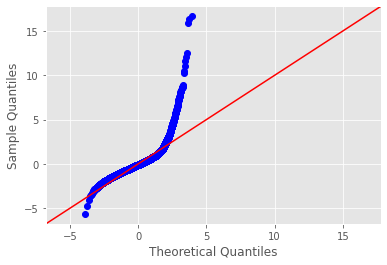

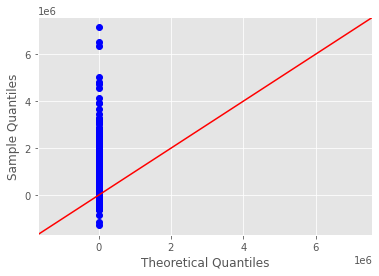

In [15]:
f3 = 'price~sqft_living'
f4 = 'price~sqft_lot'
model3 = smf.ols(formula=f3, data=raw_data).fit()
model4 = smf.ols(formula=f4, data=raw_data).fit()

resid3 = model3.resid
resid4 = model4.resid
fig = sm.graphics.qqplot(resid3, dist=stats.norm, line='45', fit=True)
fig = sm.graphics.qqplot(resid4, dist=stats.norm, line='45', fit=True)

In [18]:
# JB test for Sqft-Living
name = ['Jarque-Bera','Prob','Skew', 'Kurtosis']
test3 = sms.jarque_bera(model3.resid)
list(zip(name, test3))

[('Jarque-Bera', 542662.604395781),
 ('Prob', 0.0),
 ('Skew', 2.8196584324835365),
 ('Kurtosis', 26.90063410219435)]

In [19]:
# JB test for Sqft-Lot
name = ['Jarque-Bera','Prob','Skew', 'Kurtosis']
test4 = sms.jarque_bera(model4.resid)
list(zip(name, test4))

[('Jarque-Bera', 1147708.007822676),
 ('Prob', 0.0),
 ('Skew', 4.029646336435128),
 ('Kurtosis', 37.791609066728746)]

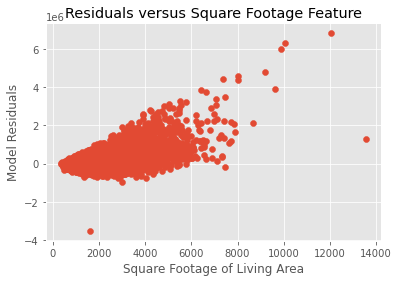

In [23]:
lwr_thresh = raw_data.sqft_living.quantile(q=.45)
upr_thresh = raw_data.sqft_living.quantile(q=.55)
middle_10percent_indices = raw_data[(raw_data.sqft_living >= lwr_thresh) & (raw_data.sqft_living <= upr_thresh)].index
# len(middle_10percent_indices)

indices = [x-1 for x in raw_data.index if x not in middle_10percent_indices]
plt.scatter(raw_data.sqft_living.iloc[indices], model.resid.iloc[indices])
plt.xlabel('Square Footage of Living Area')
plt.ylabel('Model Residuals')
plt.title("Residuals versus Square Footage Feature")
plt.vlines(lwr_thresh, ymax=8, ymin=-8, linestyles='dashed',linewidth=2)
plt.vlines(upr_thresh, ymax=8, ymin=-8, linestyles='dashed',linewidth=2);

In [24]:
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(model3.resid.iloc[indices], model3.model.exog[indices])
list(zip(name, test))

[('F statistic', 0.9159859051813802), ('p-value', 0.9999921364751672)]

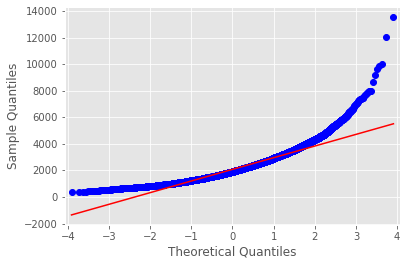

In [26]:
fig = sm.qqplot(raw_data['sqft_living'], line='r')